# Исследование по определению перспективного тарифа для телеком-компании

# Table of contents

1. [Описание проекта](##Introduction)
 1. [План работ](###subparagraph1)
2. [Общая информация](##paragraph1)
3. [Подготовка данных](##paragraph2)
4. [Анализ данных](##paragraph3)
5. [Проверка гипотез](##paragraph4)
 1. [Гипотеза 1](###subparagraph2)
 2. [Гипотеза 2](###subparagraph3)
6. [Вывод](##paragraph5)

## Описание проекта

Цель исследовнаия - определить перспективный тариф для телеком-компании "Мегалайн". В нашем распоряжении выборка в 500 клиентов компании, пользователей тарифов "Смарт" и "Ультра", за 2018 год: количество звонков и  их продолжительность, количесвто потреблённого Интернет-трафика, количесвто отправленных смс, стоимость тарифов, информация о клиентах и т. д. 

### План работ 

Нам предстоит: 

1) Загрузить необходимые библиотеки; 

2) Оценить данные и провести работу с ними (при необходимости: замена типов данных и заполнение пропусков);

3) Посчитать для каждого пользователя: 

- количество сделанных звонков и израсходованных минут разговора по месяцам;

- количество отправленных сообщений по месяцам;

- объем израсходованного интернет-трафика по месяцам;

- помесячную выручку с каждого пользователя; 

4) Описать поведение клиентов оператора: 

- сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц;

- посчитайте среднее количество, дисперсию и стандартное отклонение; 

- постройте гистограммы;

- описать распределения.

5) Проверить гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

6) Проверить гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Общая информация

Подключим необходимые для исследования библиотеки.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st

Загрузим датасеты.

In [3]:
try:
    calls, internet, messages, tariffs, users = (pd.read_csv('/datasets/calls.csv'),
                                                 pd.read_csv('/datasets/internet.csv'),
                                                 pd.read_csv('/datasets/messages.csv'),
                                                 pd.read_csv('/datasets/tariffs.csv'),
                                                 pd.read_csv('/datasets/users.csv'))
except:
    calls, internet, messages, tariffs, users = (pd.read_csv('C:/Users/Пользователь/Downloads/calls.csv'),
                                                 pd.read_csv('C:/Users/Пользователь/Downloads/internet.csv'),
                                                 pd.read_csv('C:/Users/Пользователь/Downloads/messages.csv'),
                                                 pd.read_csv('C:/Users/Пользователь/Downloads/tariffs.csv'),
                                                 pd.read_csv('C:/Users/Пользователь/Downloads/users.csv'))
    

## Подготовка данных

Посмотрим на данные.

In [6]:
calls.info()
internet.info()
messages.info()
tariffs.info()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 co

Пропуски данных видим только в одном месте - датасет по пользователям, колонка "churn_date". Эти пропуски заполнять не будем - колонка отражает срок окончания пользования тарифом.

Нулевые значения в продолжительности звонков в датасете "calls" также не будем менять - это неотвеченные звонки. 

А вот типы данных заменить придётся. В первую очередь это касается типа "даты и времени". 

Кроме того, добавим в датасеты столбцы с месяцами. 

In [7]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

По условиям, оператор округляет минуту в большую стороны. Сделаем тоже.

In [8]:
calls['duration'] = np.ceil(calls['duration'])

In [9]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

Посмотрим сколько требуется каждому пользователю минут общения помесячно.

In [11]:
calls_pivot = calls.pivot_table(index = ('user_id', 'month'), values = 'duration', aggfunc = ['count', 'sum'])
calls_pivot

count      sum
              duration duration
user_id month                  
1000    5           22    159.0
        6           43    172.0
        7           47    340.0
        8           52    408.0
        9           58    466.0
...                ...      ...
1498    10          41    247.0
1499    9            9     70.0
        10          68    449.0
        11          74    612.0
        12          69    492.0

[3174 rows x 2 columns]

Посмотрим сколько требуется каждому пользователю сообщений помесячно.

In [12]:
messages_pivot = messages.pivot_table(index = ('user_id', 'month'), values = 'message_date', aggfunc = 'count')
messages_pivot

message_date
user_id month              
1000    5                22
        6                60
        7                75
        8                81
        9                57
...                     ...
1498    10               42
1499    9                11
        10               48
        11               59
        12               66

[2717 rows x 1 columns]

Посмотрим сколько требуется каждому пользователю Интернет-трафика помесячно. 

По условиям исследования, оператор считает потреблённый Интернет-трафик в гигобайтах за месяц, округленный в большую сторону.

Переведём мегабайты в гигобайты и округлим полученный результат.

In [13]:
internet_pivot = internet.pivot_table(index = ('user_id', 'month'), values = 'mb_used', aggfunc = 'sum')
internet_pivot['mb_used'] = internet_pivot['mb_used'] / 1024
def internet_round_up(digit):
    return math.ceil(digit)
internet_pivot['mb_used'] = internet_pivot['mb_used'].apply(internet_round_up)
internet_pivot

mb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15
...                ...
1498    10          21
1499    9            2
        10          18
        11          18
        12          13

[3203 rows x 1 columns]

Объединим интересующие нас сводные данные по потреблённым ресурсам в один датасет. 

Добавим столбец с тарифом для каждого пользователя.

In [14]:
data_new = calls_pivot.join(messages_pivot)
data_new = data_new.join(internet_pivot)


data_new.columns = ['calls_count', 'calls_minute', 'messages_count', 'gb_used']
for user in data_new.index:
    data_new.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

data_new['messages_count'] = data_new['messages_count'].fillna(0)
data_new['calls_minute'] = data_new['calls_minute'].fillna(0)
data_new['gb_used'] = data_new['gb_used'] .fillna(0)
data_new.head(15)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_12872\2590589026.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data_new = calls_pivot.join(messages_pivot)


calls_count  calls_minute  messages_count  gb_used tariff
user_id month                                                           
1000    5               22         159.0            22.0      3.0  ultra
        6               43         172.0            60.0     23.0  ultra
        7               47         340.0            75.0     14.0  ultra
        8               52         408.0            81.0     14.0  ultra
        9               58         466.0            57.0     15.0  ultra
        10              57         350.0            73.0     15.0  ultra
        11              43         338.0            58.0     15.0  ultra
        12              46         333.0            70.0     10.0  ultra
1001    11              59         430.0             0.0     18.0  smart
        12              63         414.0             0.0     14.0  smart
1002    6               15         117.0             4.0     11.0  smart
        7               26         214.0            11.0     18.0  smart
        8               42         289.0            13.0     20.0  smart
        9               36         206.0             4.0     17.0  smart
        10              33         212.0            10.0     14.0  smart

Посчитаем, помесячную выручку для каждого пользователя. 

Для этого напишем функцию, которая будет возвращать, в зависимости от тарифа, сумму потраченных свер лимита ресурсвов, умноженных на соотвествующую цену, и помесячной абонентской платы. 

Чтобы избежать итоговых отрицательных значений, если у абонента не было потреблённых ресурсов сверхлимита, будем принимать сверхзначения за ноль.

Полученные результаты добавим в отдельный столбец "revenue". 

In [15]:
def profit (row):
    duration = row['calls_minute']
    messages = row['messages_count']
    gb = row['gb_used']
    tariff = row['tariff']
    
    
    if tariff == 'ultra':
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_gb = gb - (tariffs.loc[1, 'mb_per_month_included'] / 1024)
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_gb < 0: extra_gb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_minute'] * extra_duration + tariffs.loc[1, 'rub_per_gb'] * extra_gb +
                tariffs.loc[1, 'rub_per_message'] * extra_messages + tariffs.loc[1, 'rub_monthly_fee'])
    else:
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_gb = gb - (tariffs.loc[0, 'mb_per_month_included'] / 1024)
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_gb < 0: extra_gb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_minute'] * extra_duration + tariffs.loc[0, 'rub_per_gb'] * extra_gb + 
                tariffs.loc[0, 'rub_per_message'] * extra_messages + tariffs.loc[0, 'rub_monthly_fee'])

In [16]:
data_new['revenue'] = data_new.apply(profit, axis = 1)
    
data_new.head(10)

calls_count  calls_minute  messages_count  gb_used tariff  \
user_id month                                                              
1000    5               22         159.0            22.0      3.0  ultra   
        6               43         172.0            60.0     23.0  ultra   
        7               47         340.0            75.0     14.0  ultra   
        8               52         408.0            81.0     14.0  ultra   
        9               58         466.0            57.0     15.0  ultra   
        10              57         350.0            73.0     15.0  ultra   
        11              43         338.0            58.0     15.0  ultra   
        12              46         333.0            70.0     10.0  ultra   
1001    11              59         430.0             0.0     18.0  smart   
        12              63         414.0             0.0     14.0  smart   

               revenue  
user_id month           
1000    5       1950.0  
        6       1950.0  
        7       1950.0  
        8       1950.0  
        9       1950.0  
        10      1950.0  
        11      1950.0  
        12      1950.0  
1001    11      1150.0  
        12       550.0

Мы решили добавить в датасет ещё один столбец, который будет содержать значение экстра-выручки, т.е. разницы выручки и обязательной абонентской платы. 

Это поможет нам посомотреть, где клиенты больше переплачивали за пользованием услугами оператора. 

In [17]:
def extra_profit(row):
    revenue = row['revenue']
    tariff = row['tariff']
    
    if tariff == 'ultra':
        return (revenue - tariffs.loc[1, 'rub_monthly_fee'])
    else:
        return (revenue - tariffs.loc[0, 'rub_monthly_fee'])

In [18]:
data_new['extra_revenue'] = data_new.apply(extra_profit, axis = 1)
    
data_new.tail(10)

calls_count  calls_minute  messages_count  gb_used tariff  \
user_id month                                                              
1497    11              64         371.0            14.0     14.0  smart   
        12              71         545.0            17.0     20.0  smart   
1498    7               23         175.0            20.0      8.0  smart   
        8               57         400.0            62.0     24.0  smart   
        9               59         471.0            44.0     22.0  smart   
        10              41         247.0            42.0     21.0  smart   
1499    9                9          70.0            11.0      2.0  smart   
        10              68         449.0            48.0     18.0  smart   
        11              74         612.0            59.0     18.0  smart   
        12              69         492.0            66.0     13.0  smart   

               revenue  extra_revenue  
user_id month                          
1497    11       550.0            0.0  
        12      1685.0         1135.0  
1498    7        550.0            0.0  
        8       2386.0         1836.0  
        9       1950.0         1400.0  
        10      1750.0         1200.0  
1499    9        550.0            0.0  
        10      1150.0          600.0  
        11      1513.0          963.0  
        12       598.0           48.0

## Анализ данных

Создадим сводную таблицу со статистикой по потреблённым ресурсам пользователями двух тарифов (среднее, дисперсия, отклонение). 

In [19]:
data_stat = data_new.pivot_table(index = 'tariff', values = ['calls_count', 'calls_minute', 'messages_count', 'gb_used', 'revenue', 'extra_revenue'],
                                          aggfunc = {'calls_count': [np.median, np.std, np.var],
                                          'calls_minute': [np.median, np.std, np.var],
                                          'messages_count': [np.median, np.std, np.var],
                                          'gb_used': [np.median, np.std, np.var],
                                          'revenue': [np.median, np.std, np.var],
                                          'extra_revenue': [np.median, np.std, np.var]})
data_stat

calls_count                         calls_minute              \
            median        std          var       median         std   
tariff                                                                
smart         60.0  25.796101   665.438829        423.0  189.325618   
ultra         75.0  42.403348  1798.043927        528.0  306.925754   

                     extra_revenue                            gb_used  \
                 var        median         std            var  median   
tariff                                                                  
smart   35844.189551         480.0  819.119853  670957.332878    17.0   
ultra   94203.418396           0.0  379.423372  143962.095301    19.0   

                            messages_count                         revenue  \
             std        var         median        std          var  median   
tariff                                                                       
smart   5.752599  33.092396           28.0  28.259437   798.595792  1030.0   
ultra   9.890432  97.820643           39.0  46.890656  2198.733603  1950.0   

                                   
               std            var  
tariff                             
smart   819.119853  670957.332878  
ultra   379.423372  143962.095301

из таблицы видим: 

•	в среднем пользователь "Смарта" совершает 60 звонков в месяц. 

•	в среднем пользователь "Смарта" говрит по телефону 423 минуты (500 минут в пакете).

•	в среднем пользователь "Смарта" тратит 17 гб Интернет-трафика (15 гб в пакете).

•	в среднем пользователь "Смарта" отправялет 28 смс-сообщений (50 в пакете). 

•	в среднем пользователь "Смарта" приносит выручки 1030 рублей (при цене тарифа в 550 рублей). 

•	в среднем пользователь "Смарта" "переплачивает" 480 рублей за пользование тарифом. 

•	в среднем пользователь "Ультра" совершает 75 звонков в месяц.

•	в среднем пользователь "Ультра" говрит по телефону 528 минуты (3000 минут в пакете).

•	в среднем пользователь "Ультра" тратит 19 гб Интернет-трафика (30 гб в пакете).

•	в среднем пользователь "Ультра" отправялет 39 смс-сообщений (1000 в пакете).

•	в среднем пользователь "Ультра" приносит выручки 1950 рублей (при цене тарифа в 1950 рублей). 

•	пользователи тарифа "Ультра" не приносят экстра-выручки. 

Создадим таблицу по пользователям тарифа "Ультра", построим матрицу гистограмм. 

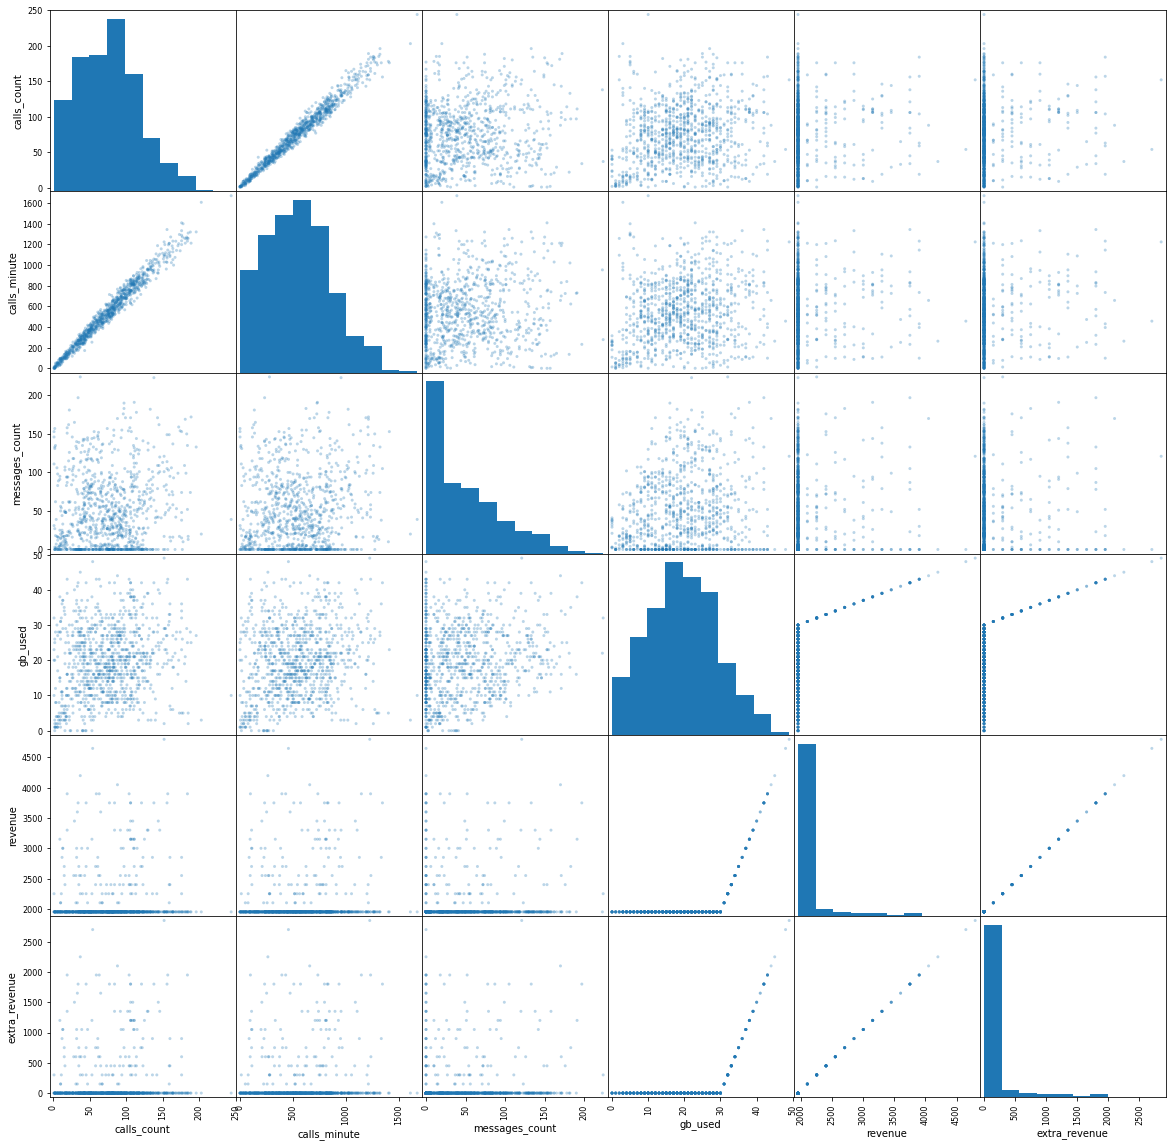

In [20]:
ultra = data_new[data_new['tariff'] == 'ultra']
ultra.describe()
pd.plotting.scatter_matrix(ultra, alpha = 0.3, figsize=(20, 20));

Тоже самое сделаем для потребителей тарифа "Смарт".

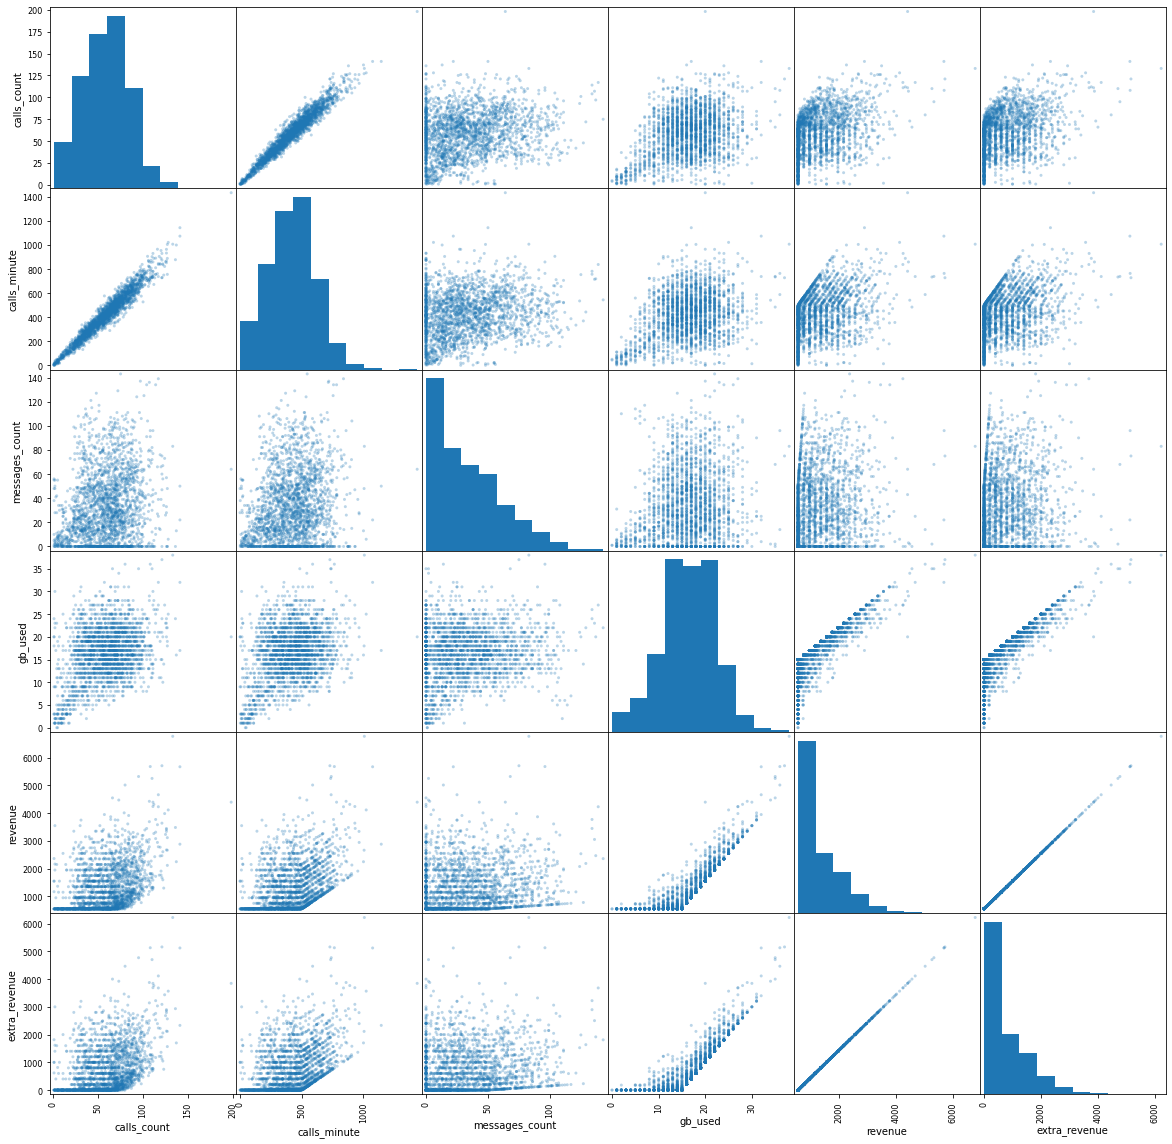

In [21]:
smart = data_new[data_new['tariff'] == 'smart']
smart.describe()
pd.plotting.scatter_matrix(smart, alpha = 0.3, figsize=(20, 20));

Кроме очевидных выводов (например, с количеством звонков растёт и количество минут) видим один примечательный. На графике видим зависимость между выручкой и экстра-выручкой и потреблёнными ресурсами, особенно количеством Гб.

Посчитаем корреляцию между экстра-выручкой и потреблёнными ресурсами для каждого тарифа. 

In [22]:
display(smart['gb_used'].corr(smart['extra_revenue']))
display(smart['calls_minute'].corr(smart['extra_revenue']))
display(smart['messages_count'].corr(smart['extra_revenue']))
display(ultra['gb_used'].corr(ultra['extra_revenue']))
display(ultra['calls_minute'].corr(ultra['extra_revenue']))
display(ultra['messages_count'].corr(ultra['extra_revenue']))

0.8480496811062321

0.41640120046082896

0.1303519874763134

0.6210235275476558

0.09246189644983753

0.017555999989111684

Видим, что между количеством потреблённых Гб и экстра-выручкой среди "смартовцев" есть сильная связь. Она также является заметной для "ультравцев". Кроме того, есть умеренная связь между продолжительностью звонков "смартовцев" и сверх-выручкой. 

А вот смс-сообщения не пользуются популярностью среди абонентов.

Построим гистограмму длительности звонков пользователями двух тарифов.

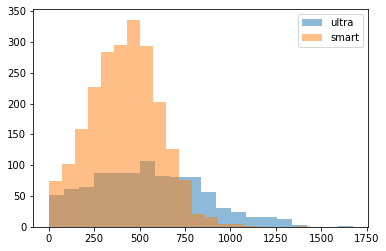

In [23]:
plt.hist(x=ultra['calls_minute'], bins=20, alpha=0.5, label='ultra')
plt.hist(x=smart['calls_minute'], bins=20, alpha=0.5, label='smart')
plt.legend(loc='upper right');

Наибольшие значения потраченных минут пользователями "смарта" тяготеют к отметке в 500 минут. Иногда чуть больше, но обычно меньше. Т.е., абоненты стараются не выходить за месячный лимит или совсем чуть переступать за него. 

С другой стороны, пользователи более дорого тарифа, которые имеют гораздо больше минут в пакете, более свободны в трате минут. График для тарифа "ультра" получился более ровный. Однако он тяготеет к отметки в 600 минут, что не сильно превышает пакет минут в тарифе "смарт". 

Можно сделать вывод, что 500 минут - это близкая к оптимальным значениям величина потребления минут в месяц абонентом.

Построим гистограмму потребления Интернет-трафика абонентами.

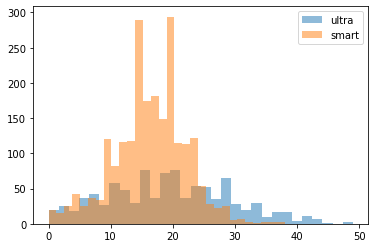

In [24]:
plt.hist(x=ultra['gb_used'], bins=30, alpha=0.5, label='ultra')
plt.hist(x=smart['gb_used'], bins=30, alpha=0.5, label='smart')
plt.legend(loc='upper right');

Для потребителей смарта видим два пика. Первый - это 15 Гб - на отметки месячного лимита, за который потребители, видимо, стараются не выходить. Второй - на отметке 22-23 Гб. За него абонентам приходится серьёзно доплачивать - по 200 руб за Гб (т.е., 1400-1600 рублей сверх абонентской платы в 550 рублей). С одной стороны, телекому это приносит дополнительную прибль. С другой, абоненты "смарта" могли бы перейти на "ультру" и тратить столько же (даже в некоторых случаях меньше), имея больший пакет ресурсов. 

Для пользователей распределение более ровное, с двумя пиками. Первый близкий к 23 Гб, второй - к "лимитной" отсечке в 30  Гб. Пользователи "ультры" в целом реже превышают свой месячный лимит. 

Можно сделать вывод, что близкой к оптимальной величине потребления абонентом Интернет-трафика ежемесячно является величина в 23 Гб. 

Построим гистограмму для смс-сообщений.

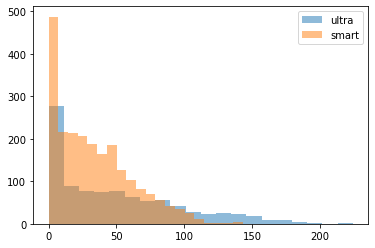

In [25]:
plt.hist(x=ultra['messages_count'], bins=20, alpha=0.5, label='ultra')
plt.hist(x=smart['messages_count'], bins=20, alpha=0.5, label='smart')
plt.legend(loc='upper right');

Пользователи обоих тарифов мало пользуются смс-сообщениями. Если "смартовцы" иногда еще выходят за свой месячный лимит, то "ультравцы" - никогда (очень большой пакет смс). 

В целом, средний абонент отправляет два десятка смс в месяц. А лимит в 50 сообщений в месяц представляется достаточным.

Построим гистограмму для прибыли и сверх-прибыли.

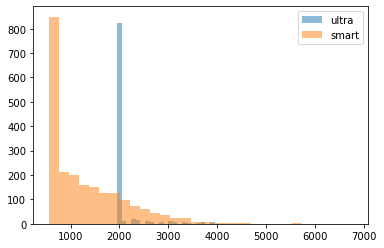

In [26]:
plt.hist(x=ultra['revenue'], bins=30, alpha=0.5, label='ultra')
plt.hist(x=smart['revenue'], bins=30, alpha=0.5, label='smart')
plt.legend(loc='upper right');

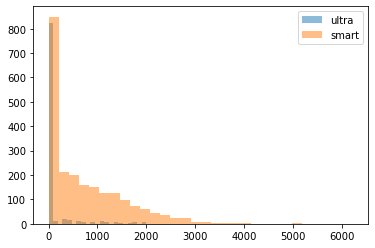

In [27]:
plt.hist(x=ultra['extra_revenue'], bins=30, alpha=0.5, label='ultra')
plt.hist(x=smart['extra_revenue'], bins=30, alpha=0.5, label='smart')
plt.legend(loc='upper right');

В случае прибыли видим, что пиковые значения на отметке ежемесячных абонентских плат. 

В случае с дополнительной выручкой за ресурсы, потреблённые сверх лимита, видим, что "смарт" генерирует её больше. 

__Вывод по сравнению тарифов__

Тариф "смарт" предлагает абонентам более оптимальный пакет, исходя их их потребления. Кроме того, генерирует экстра-выручку.

## Проверка гипотез

### Гипотеза 1

Проверяем гипотезу о неравенстве среднего чека пользователей двух тарифов.

В качестве нулевой гипотезы примем положении о равентсве значений выборок. Альтернативная гипотеза будет звучать так:

__Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.__


In [29]:
alpha = .05
results = st.ttest_ind(smart['revenue'], ultra['revenue'], equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отврегаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 3.155173205867294e-245
Отврегаем нулевую гипотезу


Получили очень низкое значение для p-value нулевой гипотезы. Нулевая гипотеза отвергается.

__Гипотеза 1 о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются, не отвергается.__

### Гипотеза 2

Проверяем гипотезу о неравентсе среднего чека жителей Москвы и остальной России.

Для каждого клиента добавим колонку с городом из датасета "users".

In [30]:
for user in data_new.index:
    data_new.loc[user, 'city'] = users.loc[user[0]-1000, 'city']
data_new.tail(10)

calls_count  calls_minute  messages_count  gb_used tariff  \
user_id month                                                              
1497    11              64         371.0            14.0     14.0  smart   
        12              71         545.0            17.0     20.0  smart   
1498    7               23         175.0            20.0      8.0  smart   
        8               57         400.0            62.0     24.0  smart   
        9               59         471.0            44.0     22.0  smart   
        10              41         247.0            42.0     21.0  smart   
1499    9                9          70.0            11.0      2.0  smart   
        10              68         449.0            48.0     18.0  smart   
        11              74         612.0            59.0     18.0  smart   
        12              69         492.0            66.0     13.0  smart   

               revenue  extra_revenue         city  
user_id month                                       
1497    11       550.0            0.0    Челябинск  
        12      1685.0         1135.0    Челябинск  
1498    7        550.0            0.0  Владикавказ  
        8       2386.0         1836.0  Владикавказ  
        9       1950.0         1400.0  Владикавказ  
        10      1750.0         1200.0  Владикавказ  
1499    9        550.0            0.0        Пермь  
        10      1150.0          600.0        Пермь  
        11      1513.0          963.0        Пермь  
        12       598.0           48.0        Пермь

Создадим две таблицы: в одну определим жителей Златоглавой, во вторую менее удачливых. 

In [31]:
moscow = data_new[data_new['city'] == 'Москва']
russia = data_new[data_new['city'] != 'Москва']

В качестве нулевой гипотезы примем положении о равентсве значений выборок. Альтернативная гипотеза будет звучать так:

__Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.__

In [32]:
alpha = .05
results = st.ttest_ind(moscow['revenue'], russia['revenue'], equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отврегаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.44113705815091153
Не получилось отвергнуть нулевую гипотезу


Значение p-value оказалось достаточно высоким. Нам не удалось опровергнуть нулевую гипотезу. Значит,

__Гипотеза 2 о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, отвергается.__

Но, что если, мы применим эту гипотезу к экстра-выручке?

В качестве нулевой гипотезы примем положении о равенстве значений выборок. Альтернативная гипотеза будет звучать так: 

__Средняя эксра-выручка пользователей из Москвы отличается от выручки пользователей из других регионов.__


In [33]:
alpha = .05
results = st.ttest_ind(moscow['extra_revenue'], russia['extra_revenue'], equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отврегаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.004755256706213009
Отврегаем нулевую гипотезу


Полученый результат говорит от том, что

Гипотеза 2.1 о том, что средняя экстра-выручка пользователей из Москвы отличается от выручки пользователей из других регионов, не отвергается

Т.е. разница между сверх-выручкой между москвичами и жителями остальной России всё-таки есть.


## Вывод

### Подготовка данных

- Мы изменили типы данных там, где это было необходимо. 

- Пропуски в данных заполнять не потребовалось. 

- В соотвествующие датасеты были добавлены столбцы с указанием месяцев, которые были использованы в дальнейших расчётах.

- Для каждого пользователя посчитали количество сделанных звонков и израсходованных минут разговора по месяцам.

- Для каждого пользователя посчитали количество отправленных сообщений по месяцам.

- Для каждого пользователя посчитали объем израсходованного интернет-трафика по месяцам.

- Посчитали помесячную выручку с каждого пользователя.

- дополнительно посчитали сверх-выручку. Это сумма дополнительных покупок абонентов, без помесячной платы за тариф.

### Анализ данных 

- Посчитали дисперсию, стандартное отклонение и среднее по потреблённым абонентами ресурссам.

- В среднем пользователь "Смарта" совершает 60 звонков в месяц. 

- В среднем пользователь "Смарта" говрит по телефону 423 минуты (500 минут в пакете).

- В среднем пользователь "Смарта" тратит 17 гб Интернет-трафика (15 гб в пакете).

- В среднем пользователь "Смарта" отправялет 28 смс-сообщений (50 в пакете). 

- В среднем пользователь "Смарта" приносит выручки 1030 рублей (при цене тарифа в 550 рублей). 

- В среднем пользователь "Смарта" "переплачивает" 480 рублей за пользование тарифом. 

- В среднем пользователь "Ультра" совершает 75 звонков в месяц.

- В среднем пользователь "Ультра" говрит по телефону 528 минуты (3000 минут в пакете).

- В среднем пользователь "Ультра" тратит 19 гб Интернет-трафика (30 гб в пакете).

- В среднем пользователь "Ультра" отправялет 39 смс-сообщений (1000 в пакете).

- В среднем пользователь "Ультра" приносит выручки 1950 рублей (при цене тарифа в 1950 рублей). 

- Пользователи тарифа "Ультра" не приносят экстра-выручки. 

- Пострили матрицу гистограмм для пользователей каждого тарифа.

- Больше всего абоненты доплачивают за дополнительный Интернет-трафик. Это относится к потребителям обоих тарифов. 

- Существует умеренная зависимсоть между сверх-выручкой и дополнительными минутами, которые покупают потребители тарифа "Смарт".

### Проверка гипотез 

- Гипотеза 1 о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются, не отвергается.

- Гипотеза 2 о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, отвергается.

- Гипотеза 2.1(дополнительная) о том, что средняя эксра-выручка пользователей из Москвы отличается от выручки пользователей из других регионов, не отвергается. Т.е., разница по дополнительным тратам между москвичами и остальными россиянам есть. 

### Сравнение тарифов

- Значения потраченных минут пользователями "смарта" тяготеют к отметке в 500 минут. Для пользователей "Ультра" - всего 600 минут, с учётом того, что они почти неограничены в этом ресурсе. 500-600 минут - это оптимальное количество минут в месяц для абонентов.


- Абоненты "смарта" стараются не выходить за лимит своего Интернет-трафика и расходуют его до конца. Часто превышают лимит, трятя по 22-23 Гб. и серьёзно доплачивают за это (1400-1600 рублей сверх абонентской платы в 550 рублей). Абоненты "ультры" реже доходят до лимита в 30 Гб. Часто останавливаясь на 23 Гб за месяц. Можно сделать вывод, что близкой к оптимальной величине потребления абонентом Интернет-трафика ежемесячно является величина в 23 Гб.

- Пользователи обоих тарифов мало пользуются смс-сообщениями. Если "смартовцы" иногда еще выходят за свой месячный лимит, то "ультравцы" - никогда (очень большой пакет смс). Средний абонент отправляет два десятка смс в месяц. Лимит в 50 сообщений в месяц представляется достаточным.

__Тариф "смарт" предлагает абонентам более оптимальный пакет, исходя из их потребления минут, смс и Интернет-трафика. Кроме того он, генерирует экстра-выручку. "Смарт" является более перспективным тарифом, отвечающим и ожиданиям абонентов (большей их части), и  более прибыльным для телекома.__
